#Projeto Aquecimento

##Breve contextualização dos dados

O projeto foi desenvolvido consolidando as bases disponibilizadas em uma única por meio do processo de ETL, utilizando como ferramentas o Colab bem como o Google Cloud e observando os seguintes parâmetros:
1. Da base de dados: 
* Os dados disponibilizados são da base dos dados de
CAT do ano de 2022 contendo os dados cadastrados no sistema informatizado de Comunicação de Acidentes do Trabalho do INSS (CATWEB) ou quando da concessão de benefício por incapacidade acidentário. Por tais dados serem efetuados por sistema, telefone e ou presencial podem existir dados divergentes ou ausentes(faltantes).
2. Nível Infra:
* O arquivo original e tratado deve ser salvo em MongoDB Atlas em coleções diferentes (enumerar com o final tratado ou original).
Os Datasets devem ser obrigatoriamente salvos em uma bucket do
CloudStorage(original e tratado).
Disponibilizar o dataset final em um mysql.
COMENTÁRIOS

3. Nível Pandas
* Realizar a extração correta para um dataframe.
* Verificar a existência de dados inconsistentes e realizar a limpeza para NaN/NA ou algum valor atribuído por você explicando o porque da decisão.
* Realizar o drop(se necessário) de colunas do dataframe realizando o
comentário do porque da exclusão
* Todos os passos devem ser comentados(exclusivos)
* Agregar todos os DF&#39;s originais em um unico DF tratado
* Criar no mínimo 3 insights dos dados apresentados podendo ser
construído com auxilio de plots.
4. Nivel PySpark
* Deverá ser montada a estrutura do DataFrame utilizando o StructType.
* Verificar a existência de dados inconsistentes, nulos e realizar a limpeza.
* Verificar a necessidade de drop em colunas ou linhas. Caso seja
necessário, fazer comentário do porque.
* Realizar a mudança de nome de pelo menos 2 colunas
* Deverá criar pelo menos duas novas colunas contendo alguma informação relevante sobre as outras colunas já existentes (Funções de Agrupamento, Agregação ou Joins). (Use a sua capacidade analítica)
* Deverá utilizar filtros, ordenação e agrupamento, trazendo dados
relevantes para o negócio em questão. (Use a sua capacidade analítica)
* Utilizar pelo menos duas Window Functions
* 5 insights utilizando SparkSQL

#1.Bibliotecas

##1.1.Instalações de Bibliotecas

In [ ]:
!pip install gcsfs # Necessário para fazer a conexão com a GCP
!pip install pyspark # Necessário para fazer a conexão com o PySpark
!pip install pymongo # Necessário para fazer a conexão com o MongoDB
!pip install pymysql # Necessário para fazer a conexão / envio com o MySQL
!pip install mysql-connector-python # Necessário para fazer a conexão com o MySQL

##1.2.Importação de Bibliotecas 

In [2]:
import pymongo 
import os
import pandas as pd
import numpy as np
import mysql.connector
import datetime
import pyspark.sql.functions as F

In [3]:
from pyspark.sql import SparkSession
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.window import Window
from mysql.connector import Error
from pyspark import SparkConf
from sqlalchemy import create_engine
from google.cloud import storage
from pymongo import MongoClient

##1.3.Conectar com Bibliotecas

###1.3.1.GCP

In [4]:
#Conexão com o drive 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
#Conecção com a GCP
serviceAccount = '/content/drive/MyDrive/BC26-ENG DADOS-PYTHON/PROJETOS/key-store-via-colab.json'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = serviceAccount

###1.3.2.Mongo

In [6]:
#conector do Mongo Atlas
uri = "mongodb+srv://nayyarabernardo-soulcod.mv7bzjn.mongodb.net/?authSource=%24external&authMechanism=MONGODB-X509&retryWrites=true&w=majority"
client = MongoClient(uri, 
                     tls=True, 
                     tlsCertificateKeyFile='/content/drive/MyDrive/BC26-ENG DADOS-PYTHON/PROJETOS/X509-cert-3376380089754927980.pem')


###1.3.3.Spark

In [7]:
#CONFIGURAR A SPARK SESSION
spark = (
   SparkSession.builder
               .master('local')
               .appName('gcsfs') 
               .config('spark.ui.port', '4050')
               .config("spark.jars", 'https://storage.googleapis.com/hadoop-lib/gcs/gcs-connector-hadoop2-latest.jar') #config acesso conector gcp
               .getOrCreate()                
)
   

#2.Load - Carregamento de dados originais - GCP e MongoDB

##2.1.Carregando os arquivos Originais para o Bucket

In [8]:
#Criar DF com arquivos
df_01 = pd.read_csv('/content/drive/MyDrive/BC26-ENG DADOS-PYTHON/PROJETOS/D.SDA.PDA.005.CAT.202201.csv', sep=';',encoding = 'ISO-8859-1')
df_02 = pd.read_csv('/content/drive/MyDrive/BC26-ENG DADOS-PYTHON/PROJETOS/D.SDA.PDA.005.CAT.202204.csv', sep=';',encoding = 'ISO-8859-1')
df_03 = pd.read_csv('/content/drive/MyDrive/BC26-ENG DADOS-PYTHON/PROJETOS/D.SDA.PDA.005.CAT.202210.csv', sep=';',encoding = 'ISO-8859-1')
#Enviar arquivo para Bucket
df_01.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202201-ORIGINAL.csv', index=False)
df_02.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202204-ORIGINAL.csv', index=False)
df_03.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202210-ORIGINAL.csv', index=False)

#3.Extract - Extração de dados do data lake

In [9]:
# DOWLOAND ARQUIVO ORGINAIS DO DATALAKE
df_1 = pd.read_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202201-ORIGINAL.csv')
df_2 = pd.read_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202204-ORIGINAL.csv')
df_3 = pd.read_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.202210-ORIGINAL.csv')

In [10]:
#Para mostrar todas as colunas no display
pd.set_option('display.max_columns',25)

##3.1Carregando os arquivos Brutos para o MongoDB

###3.1.1.Tratamento de inconsistências para envio ao MongoDB

####3.1.1.1.Pre Analise para envio

In [11]:
#Replece de virgulas, espaços, barras e parênteses
df_1.replace(['{', '}','\('],'',regex=True,inplace=True)
df_2.replace(['{', '}','\('],'',regex=True,inplace=True)
df_3.replace(['{', '}','\('],'',regex=True,inplace=True)

In [12]:
#Dividir o df_2 em dois DF para poder fazer ulpload para Mongo
df_02_parte1 = df_02[0:40001]
df_02_parte2 = df_02[40001:80001]
df_02_parte3 = df_02[80001:89603]

###3.1.2.Carregamento do arquivo o MongoDB

In [13]:
# #Criar conexão
# db = client['CAT-PROJETO']

In [14]:
# # #Criar e enviar coleção ORIGINAL  
# colecao_1 = db['D.SDA.PDA.005.CAT.202201-ORIGINAL']
# df1_dict = df_1.to_dict('records')
# # Inserindo os dados no mongodb
# colecao_1.insert_many(df1_dict)

In [15]:
# colecao_2_parte1 = db['D.SDA.PDA.005.CAT.202204-PARTE1-ORIGINAL']
# df2_dict_parte1 = df_02_parte1.to_dict('records')
# colecao_2_parte1.insert_many(df2_dict_parte1)

In [16]:
# colecao_2_parte2 = db['D.SDA.PDA.005.CAT.202204-PARTE2-ORIGINAL']
# df2_dict_parte2 = df_02_parte2.to_dict('records')
# colecao_2_parte2.insert_many(df2_dict_parte2)

In [17]:
# colecao_2_parte3 = db['D.SDA.PDA.005.CAT.202204-PARTE3-ORIGINAL']
# df2_dict_parte3 = df_02_parte3.to_dict('records')
# colecao_2_parte3.insert_many(df2_dict_parte3)

In [18]:
# colecao_3 = db['D.SDA.PDA.005.CAT.202210-ORIGINAL']
# df3_dict = df_3.to_dict('records')
# colecao_3.insert_many(df3_dict)

#4.Transform - Tratamento utilizando Pandas e PySpark

##4.1.PANDAS 

###4.1.2.Tratamento

In [19]:
#Junção dos DataFrames
geral = [df_1,df_2,df_3]
df_geral = pd.concat(geral)

In [20]:
#Backap do DF GERAL geral
dfbackgeral_3 = df_geral.copy()

In [21]:
##DROP de colunas desnecessarias pois é repetitiva em relação a coluna Data nascimento ja existente 

df_geral.drop(['Data Acidente', 'Data Acidente.1'], axis=1, inplace = True)

In [22]:
#Renomeando as colunas - 

df_geral.rename(columns={'Agente  Causador  Acidente':'Agente_Causador_Acidente',
                         'CBO':'Codigo_Ocupacao',
                         'CID-10':'Identificação_da_doenca',
                         'CNAE2.0 Empregador':'CNAE_COD_Atividade_Economica',
                         'CNAE2.0 Empregador.1':'CNAE_Atividade_Economica',
                         'Emitente CAT':'Emitente_CAT',
                         'Espécie do benefício':'Especie_do_beneficio',
                         'Filiação Segurado':'Filiação_Segurado',
                         'Indica Óbito Acidente':'Indica_Obito_Acidente',
                         'Munic Empr':'Municipio_Empregador',
                         'Origem de Cadastramento CAT':'Origem_Cadastramento_CAT',
                         'Parte Corpo Atingida': 'Parte_Corpo_Atingida',
                         'UF  Munic.  Acidente':'UF_Municipio_Acidente',
                         'UF Munic. Empregador':'UF_Municipio_Empregador',
                         'Data Despacho Benefício':'Data_Despacho_Beneficio',
                         'Data Acidente.2':'Data_Acidente',
                         'Data Nascimento':'Data_Nascimento',
                         'Data Emissão CAT':'Data_Emissao_CAT',                         
                         'CNPJ/CEI Empregador':'CNPJ_Empregador'}, inplace=True)

In [23]:
#removendo os espaços antes e depois da str
cols = ['Agente_Causador_Acidente',
        'Codigo_Ocupacao',
        'Identificação_da_doenca',
        'CNAE_Atividade_Economica',
        'Emitente_CAT',
        'Especie_do_beneficio',
        'Filiação_Segurado',
        'Indica_Obito_Acidente',
        'Municipio_Empregador',
        'Natureza da Lesão',
        'Origem_Cadastramento_CAT',
        'Parte_Corpo_Atingida',
        'Sexo',
        'Tipo do Acidente',
        'UF_Municipio_Acidente',
        'UF_Municipio_Empregador',
        'CNPJ_Empregador']

for i in cols:
  df_geral[i] = df_geral[i].str.strip()


In [24]:
#Removendo inconsistência de datas
def to_NaN(DataFrame, name):
    for n in DataFrame:
      DataFrame.replace([name], np.nan,inplace=True)

to_NaN(df_geral,'0000/00')
to_NaN(df_geral,'00/00/0000')

In [25]:
#Removendo inconsistência de strings
df_geral.replace(['000000-Não Informado', 'Ignorado', '{ñ',
                  '{ñ class',
                  '{ñ class}',
                  'Ignorado-Zerado',
                  'ñ class',
                  '0',
                  '00.000.000.000.000',
                  'Zerado'], 'Não Informado', inplace=True)

In [26]:
#Remodevndo os NA por NaN
df_geral.replace(pd.NA, np.NaN, inplace=True)

In [27]:
#Mudança de tipo das colunas
df_geral['Data_Despacho_Beneficio'] = pd.to_datetime(df_geral['Data_Despacho_Beneficio'], format='%Y/%m')
df_geral['Data_Acidente']= pd.to_datetime(df_geral['Data_Acidente'], dayfirst=True)
df_geral['Data_Nascimento']= pd.to_datetime(df_geral['Data_Nascimento'], dayfirst=True)
df_geral['Data_Emissao_CAT']= pd.to_datetime(df_geral['Data_Emissao_CAT'], dayfirst=True)

##4.2.PYSPARK

In [28]:
#Enviar arquivo Bruto Geral  para Bucket
df_geral.to_csv('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.GERAL.csv', index=False)

Montando a estrutura do DataFrame utilizando o StructType
- O objeto StructType é a coleção de objetos StructFields. É um tipo de dados interno que contém a lista de StructField.

In [29]:
schema = StructType([StructField('Agente_Causador_Acidente',StringType(), True),
                     StructField('Codigo_Ocupacao', StringType(), True),
                     StructField('Identificação_da_doenca',StringType(), True),
                     StructField('CNAE_COD_Atividade_Economica',IntegerType(), True),
                     StructField('CNAE_Atividade_Economica',StringType(), True),
                     StructField('Emitente_CAT',StringType(), True),
                     StructField('Especie_do_beneficio',StringType(), True),
                     StructField('Filiação_Segurado',StringType(), True),
                     StructField('Indica_Obito_Acidente',StringType(), True),
                     StructField('Municipio_Empregador',StringType(), True),
                     StructField('Natureza_da_Lesao',StringType(), True),
                     StructField('Origem_Cadastramento_CAT',StringType(), True),
                     StructField('Parte_Corpo_Atingida',StringType(), True),
                     StructField('Sexo',StringType(), True),
                     StructField('Tipo_do_Acidente',StringType(), True),
                     StructField('UF_Municipio_Acidente',StringType(), True),
                     StructField('UF_Municipio_Empregador',StringType(), True),
                     StructField('Data_Despacho_Beneficio',DateType(),True),
                     StructField('Data_Acidente',DateType(),True),
                     StructField('Data Nascimento',DateType(),True),
                     StructField('Data Emissão CAT',DateType(),True),
                     StructField('CNPJ_Empregador',StringType(), True)                   
                   ])

In [30]:
#AQUI IREMOS LER O DATAFRAME COLOCANDO INFERSCHEMA COMO FALSE PARA QUE O SPARK NÃO INFIRA O ESQUEMA
# E ADICIONAMOS schema=esquema, PARA UTILIZARMOS O ESQUEMA QUE CRIAMOS ANTERIORMENTE
df = (
    spark.read.format('csv')
              .option('header', 'true')
              .option('inferschema', 'false')
              .option('delimiter', ',')
              .load('gs://projeto_cat/ORIGINAL/D.SDA.PDA.005.CAT.GERAL.csv', schema = schema)
)

###4.2.1.Tratamento

In [31]:
#Renomear uma coluna no Pyspark
df = (df.withColumnRenamed('Data Nascimento', 'Data_Nascimento')
        .withColumnRenamed('Data Emissão CAT', 'Data_Emissão_CAT'))

In [32]:
# Drop linhas duplicadas no dataframe
df = df.dropDuplicates()
df = df.distinct()

In [33]:
#Criação de novas colunas 
df = df.withColumn('CNAE_COD_Atividade_Economica', df['CNAE_COD_Atividade_Economica'].cast(StringType()))
df = (df.withColumn('CNAE', F.concat(F.col('CNAE_COD_Atividade_Economica'), F.lit('-'), F.col('CNAE_Atividade_Economica'))) \
          .withColumn('Quant_dias_Emisão_CAT', F.datediff('Data_Emissão_CAT','Data_Acidente'))   
       )
df = df.withColumn('CNAE_COD_Atividade_Economica', df['CNAE_COD_Atividade_Economica'].cast(IntegerType()))

#5.Load - Carregamento de dados Tratados para GCP, MONGODB e MySQL

##5.1.Load - Dataset final Para bucket do CloudStorage

In [34]:
#transformar de Pypark para PANDAS
df_geral2 = df.toPandas()

In [35]:
df_geral2.to_csv('gs://projeto_cat/TRATADOS/D.SDA.PDA.005.CAT.2022-TRATADOS.csv', index=False)

##5.2.Load - Dataset final Para Banco de Dados MySQL.

###5.2.1.Conectar com o Banco de dados

In [ ]:
# # dados de para realizar conexão com o servidor
# servidor = 'xxxxxxx'
# nome_do_banco = 'xxxxx'
# usuario = 'xxxxx'
# senha = 'xxxxx'

# # ciar uma SQLAlchemy engine para conectar com o MySQL 
# engine = create_engine("mysql+pymysql://{user}:{pw}@{host}/{db}"
# 				.format(host=servidor, db=nome_do_banco, user=usuario, pw=senha))

# # convertendo dataframe em uma table do sql                                   
# df_geral2.to_sql('cat_tratado', engine, index=True, index_label="id")

In [37]:
# engine.execute('ALTER TABLE cat_tratado ADD PRIMARY KEY (id);')

##5.3.Load - Dataset final Para o MongoDB

In [38]:
# #Tranformação do formato das datas para serem aceitos no mongo db
# df_geral2['Data_Despacho_Beneficio']= df_geral2['Data_Despacho_Beneficio'].dt.strftime('%Y-%m-%d %H:%M:%s')
# df_geral2['Data_Acidente']= df_geral2['Data_Acidente'].dt.strftime('%Y-%m-%d %H:%M:%s')
# df_geral2['Data_Nascimento']= df_geral2['Data_Nascimento'].dt.strftime('%Y-%m-%d %H:%M:%s')
# df_geral2['Data_Emissão_CAT']= df_geral2['Data_Emissão_CAT'].dt.strftime('%Y-%m-%d %H:%M:%s')

In [39]:
# #Dividir o df_geral2 em dois DF para poder fazer Upload para Mongo
# df_geral2_parte1 = df_geral2.loc[0:40000]
# df_geral2_parte2 = df_geral2.loc[40001:80000]
# df_geral2_parte3 = df_geral2.loc[80001:120000]
# df_geral2_parte4 = df_geral2.loc[120001:156749]

In [40]:
# # enviar o DF para colecao selecionada no mongo
# colecao_4_parte1 = db['D.SDA.PDA.005.CAT.2022-TRATADO-parte1']
# df_pd_dict1 = df_geral2_parte1.to_dict("records")
# colecao_4_parte1.insert_many(df_pd_dict1)

In [41]:
# colecao_4_parte2 = db['D.SDA.PDA.005.CAT.2022-TRATADO-parte2']
# df_pd_dict2 = df_geral2_parte2.to_dict('records')
# colecao_4_parte2.insert_many(df_pd_dict2)

In [42]:
# colecao_4_parte3 = db['D.SDA.PDA.005.CAT.2022-TRATADO-parte3']
# df_pd_dict3 = df_geral2_parte3.to_dict('records')
# colecao_4_parte3.insert_many(df_pd_dict3)

In [43]:
# colecao_4_parte4 = db['D.SDA.PDA.005.CAT.2022-TRATADO-parte4']
# df_pd_dict4 = df_geral2_parte4.to_dict('records')
# colecao_4_parte4.insert_many(df_pd_dict4)

#6.Insights

##6.1.Pandas

####1 - Quais as profissões que ocorrem mais acidente de trabalho - 

In [44]:
#Groupby Para descobrir as mais informadas
df_geral.groupby(['Codigo_Ocupacao']).size().sort_values(ascending=False)

Codigo_Ocupacao
Não Informado                                    107813
322205-Tec. de Enfermagem                         11824
784205-Alimentador de Linha de Prod.              10582
782510-Motorista de Caminhão Rotas Regionais       4109
717020-Servente de Obras                           3788
                                                  ...  
821235-Oper. Aciaria Dessulfuração de Gusa)           1
821325-Oper. Laminador de Tubos                       1
263110-Missionário                                    1
311305-Tec. Materiais, Prod. Cerâmicos e Vidr         1
010105-Oficial General da Aeronáutica                 1
Length: 1556, dtype: int64

In [45]:
#Quero que apenas apareça as profissões com mais acidentes
df_geral_sem_nan = df_geral[~df_geral['Codigo_Ocupacao'].isin(["000000-Não Informado", "Não Informado"])]

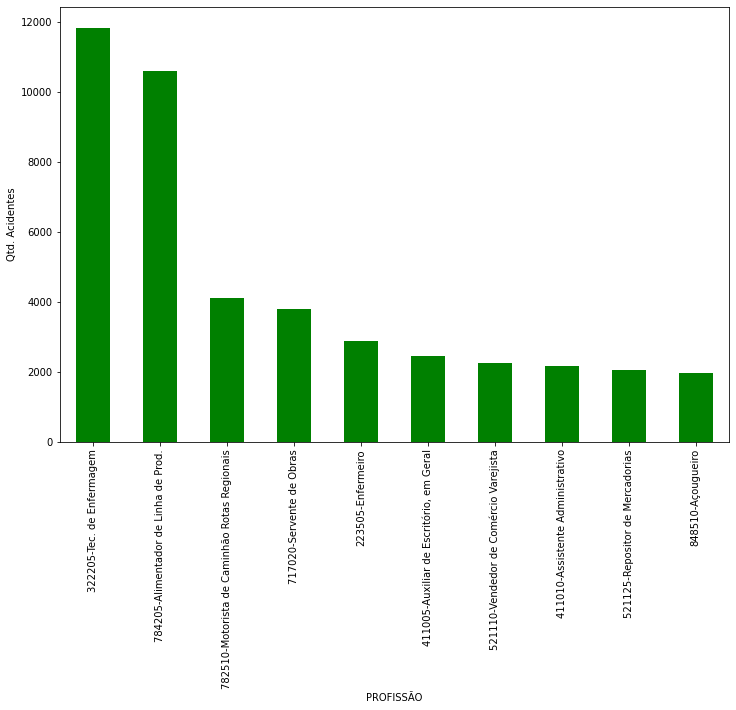

In [46]:
df_geral_sem_nan.groupby(['Codigo_Ocupacao'],dropna=True).size().sort_values(ascending=False).head(10).plot.bar(figsize=(12,8),xlabel='PROFISSÃO',ylabel='Qtd. Acidentes', color='green')

####2 - Em que região ocorre mais acidentes de trabalho? 

In [47]:
#Quero que apenas apareça as profissões com mais acidentes
df_geral_sem_nao = df_geral[~df_geral['UF_Municipio_Acidente'].isin(["Não Informado"])]

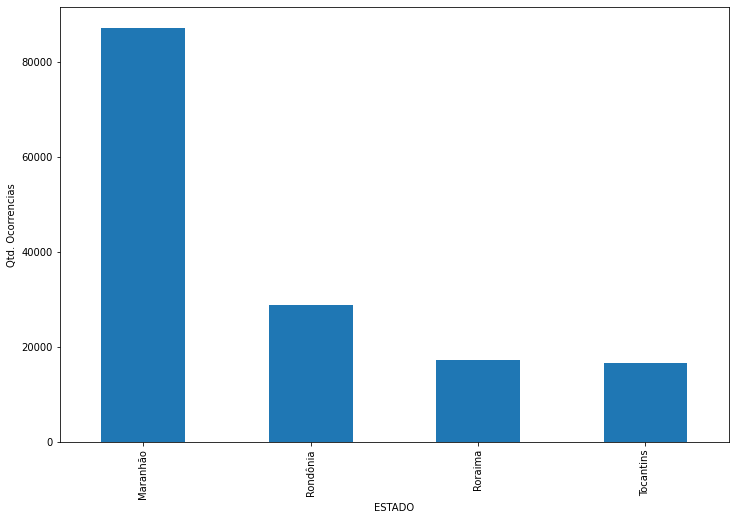

In [48]:
df_geral_sem_nao.groupby(['UF_Municipio_Acidente'],dropna=True).size().sort_values(ascending=False).head(4).plot.bar(figsize=(12,8),xlabel='ESTADO',ylabel='Qtd. Ocorrencias')

####3 - Quando ocorre mais acidentes. Em que época.

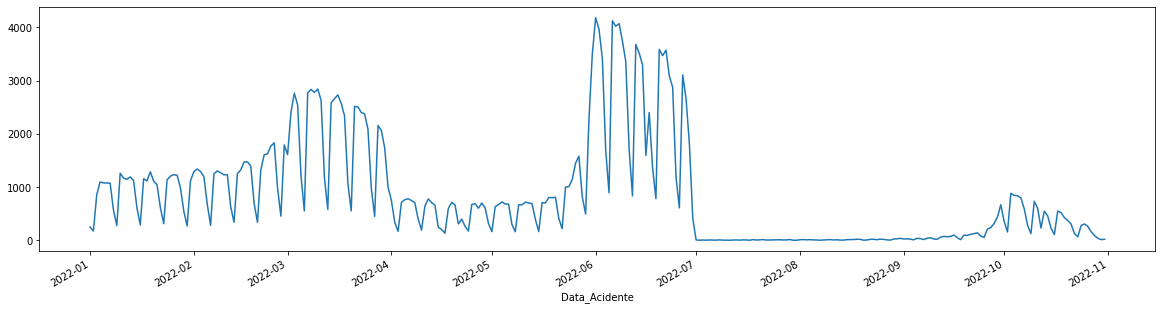

In [49]:
df_geral.groupby(['Data_Acidente'],dropna=False).size().sort_values(ascending=False).plot.line(figsize=(20,5))

##6.2.PySpark

###6.2.1.Filtros

In [50]:
#O sexo que mais solicita com o pedido de Auxilio Doença
df.groupBy('Sexo').count().show()

+-------------+------+
|         Sexo| count|
+-------------+------+
|Indeterminado|     2|
|Não Informado|   502|
|     Feminino| 53328|
|    Masculino|102917|
+-------------+------+



In [51]:
df.filter(F.col('UF_Municipio_Acidente').contains('Alagoas')).show(truncate=False)

+---------------------------------------------+---------------------------------------------+---------------------------------------------+----------------------------+---------------------------------------------+-------------+---------------------------------------+-----------------+---------------------+--------------------+------------------------------------------+------------------------+---------------------------------------------+---------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+------------------+--------------------------------------------------+---------------------+
|Agente_Causador_Acidente                     |Codigo_Ocupacao                              |Identificação_da_doenca                      |CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica                     |Emitente_CAT |Especie_do_beneficio                   |Filiação_Segurado|Indica_Obito_Acidente|Municipio_Em

###6.2.2.SparkSQL

In [52]:
#Criar tabela em tempo de execução para realização de consulta
df.createOrReplaceTempView("dfsql")

In [53]:
spark.sql(
    'SELECT * FROM dfsql limit 10;'
).show()

+------------------------+--------------------+-----------------------+----------------------------+------------------------+-------------+--------------------+-----------------+---------------------+--------------------+--------------------+------------------------+--------------------+---------+----------------+---------------------+-----------------------+-----------------------+-------------+---------------+----------------+------------------+--------------------+---------------------+
|Agente_Causador_Acidente|     Codigo_Ocupacao|Identificação_da_doenca|CNAE_COD_Atividade_Economica|CNAE_Atividade_Economica| Emitente_CAT|Especie_do_beneficio|Filiação_Segurado|Indica_Obito_Acidente|Municipio_Empregador|   Natureza_da_Lesao|Origem_Cadastramento_CAT|Parte_Corpo_Atingida|     Sexo|Tipo_do_Acidente|UF_Municipio_Acidente|UF_Municipio_Empregador|Data_Despacho_Beneficio|Data_Acidente|Data_Nascimento|Data_Emissão_CAT|   CNPJ_Empregador|                CNAE|Quant_dias_Emisão_CAT|
+---------

In [55]:
#quais ocupações estão mais associadas a determinadas lesões

spark.sql('SELECT Codigo_Ocupacao, Natureza_da_Lesao, COUNT(*) \
          FROM dfsql \
          GROUP BY Codigo_Ocupacao, Natureza_da_Lesao \
          ORDER BY COUNT(*) DESC').show(10, truncate=False)

+------------------------------------+------------------------------------------+--------+
|Codigo_Ocupacao                     |Natureza_da_Lesao                         |count(1)|
+------------------------------------+------------------------------------------+--------+
|Não Informado                       |Não Informado                             |39955   |
|784205-Alimentador de Linha de Prod.|Corte, Laceracao, Ferida Contusa, Punctura|1903    |
|Não Informado                       |Fratura                                   |1896    |
|Não Informado                       |Corte, Laceracao, Ferida Contusa, Punctura|1867    |
|322205-Tec. de Enfermagem           |Lesao Imediata                            |1532    |
|Não Informado                       |Lesao Imediata                            |1501    |
|322205-Tec. de Enfermagem           |Corte, Laceracao, Ferida Contusa, Punctura|1462    |
|784205-Alimentador de Linha de Prod.|Fratura                                   |1246    |

In [56]:

#Qual é a atividade econômica mais comum entre os acidentados?

spark.sql('SELECT CNAE_Atividade_Economica, \
          COUNT(*) AS Numero_Acidentados\
          FROM dfsql \
          GROUP BY CNAE_Atividade_Economica \
          ORDER BY Numero_Acidentados DESC \
          LIMIT 5').show(10, truncate=False)


+---------------------------------------------+------------------+
|CNAE_Atividade_Economica                     |Numero_Acidentados|
+---------------------------------------------+------------------+
|Não Informado                                |43857             |
|Atividades de Atendimento Hospitalar         |12578             |
|Comercio Varejista de Mercadorias em Geral, c|4789              |
|Administracao Publica em Geral               |3236              |
|Transporte Rodoviario de Carga               |3230              |
+---------------------------------------------+------------------+



In [57]:
#Qual é a relação entre a Natureza da Lesão e a Parte do Corpo Atingida?
spark.sql('SELECT Natureza_da_Lesao, Parte_Corpo_Atingida \
           FROM dfsql \
           GROUP BY Natureza_da_Lesao, Parte_Corpo_Atingida').show(10, truncate=False)

+------------------------------------------+--------------------------------------------+
|Natureza_da_Lesao                         |Parte_Corpo_Atingida                        |
+------------------------------------------+--------------------------------------------+
|Escoriacao, Abrasao Ferimento Superficial)|Antebraco Entre O Punho e O Cotovelo)       |
|Doenca, Nic                               |Tronco, Nic                                 |
|Hernia de Qualquer Natureza, Ruptura      |Abdome Inclusive Orgaos Internos)           |
|Hernia de Qualquer Natureza, Ruptura      |Sistema Musculo-Esqueletico                 |
|Asfixia, Estrangulamento, Afogamento      |Localizacao da Lesao, Nic                   |
|Lesoes Multiplas                          |Cabeca, Partes Multiplas Qualquer Combinacao|
|Fratura                                   |Coxa                                        |
|Queimadura Quimica Lesao de Tecido Provoca|Braco Entre O Punho a O Ombro)              |
|Perda ou 